# Transfermarkt Transfers

**Disclaimers** : 
- The analysis scope is based on the dataset, especially on the defined transfer date range. Some info and numbers may differ from the real complete data out there.
- Some data may be missing because of scraping issue or restricted by the transfermarkt themselves. These could causing an innacurate conclusions.

The dataset was politely scraped from [transfermarkt.com](https://www.transfermarkt.com/statistik/transfertage) using Scrapy and Splash. The notebook will be updated as the scraping goes from time to time. Check the `Transfer Date Range` section below to find out the oldest and latest date.

## Preparation

### Import Libraries

In [825]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas version:  1.3.4
seaborn version:  0.11.2
last run:  2022-01-17 19:49:53


### Loading Dataset

In [826]:
dataset = pd.read_csv("transfermarkt-transfers.csv")

# developer-friendly column names and format
dataset.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in dataset.columns.to_list()]

### Variables and Functions

In [827]:
binary_pallete = ['#EF4444', '#10B981']
binary_order = ['No', 'Yes']

def remove_outlier_iqr(dataset, col):
    filtered_entries = np.array([True] * len(dataset))
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((dataset[col] >= low_limit) & (dataset[col] <= high_limit)) & filtered_entries

    dataset = dataset[filtered_entries]
    return dataset

## Dataset Exploration

In [828]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89405 entries, 0 to 89404
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            88352 non-null  float64
 1   name                 89405 non-null  object 
 2   age                  88937 non-null  float64
 3   position             89405 non-null  object 
 4   national_1           75344 non-null  object 
 5   national_2           11496 non-null  object 
 6   left_club            88449 non-null  object 
 7   left_club_league     64869 non-null  object 
 8   joined_club          87812 non-null  object 
 9   joined_club_league   60878 non-null  object 
 10  transfer_date        89405 non-null  object 
 11  transfer_date_p      89405 non-null  object 
 12  market_value         89405 non-null  object 
 13  market_value_p       89405 non-null  int64  
 14  fee                  89401 non-null  object 
 15  left_club_country    82226 non-null 

- The dataset has `23 columns` and `89404 rows` (the number will keep increasing)
- The default features mostly are object or categorical, but has a few numerical features too.

In [829]:
dataset.sample(10, random_state=1)

,player_id,name,age,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,market_value_p,fee,left_club_country,joined_club_country,loan_fee,loan_fee_p,created_at,updated_at,temp_dates_page,temp_players_page
8414,394304.0,Manolo Portanova,20.0,Attacking Midfield,Italy,NaN,Juventus U23,Serie C - A,Juventus,Serie A,"Oct 1, 2020",2020-10-01,€600Th.,600000,-,Italy,Italy,NaN,NaN,2021-10-04 16:24:18,2021-10-04 16:24:18,NaN,NaN
16712,183499.0,Shkodran Maholli,27.0,Centre-Forward,Sweden,Kosovo,Silkeborg IF,1.Division,Helsingborg,Allsvenskan,"Aug 25, 2020",2020-08-25,€200Th.,200000,free transfer,Denmark,Sweden,NaN,NaN,2021-10-04 17:02:02,2021-10-04 17:02:02,NaN,NaN
52724,247921.0,Rafa de Vicente,27.0,Central Midfield,NaN,NaN,UCAM Murcia,Primera Div. R.F.E.F. - Gr. II,Dep. La Coruña,Primera Div. R.F.E.F. - Gr. I,"Jul 1, 2021",2021-07-01,€250Th.,250000,free transfer,Spain,Spain,NaN,NaN,2021-12-13 23:38:36,2021-12-13 23:38:36,NaN,92.0
81407,157036.0,Dyego Sousa,31.0,Centre-Forward,NaN,NaN,SZ FC,Super League,UD Almería,LaLiga2,"Aug 31, 2021",2021-08-31,€1.80m,1800000,free transfer,China,Spain,NaN,NaN,2021-12-31 06:58:33,2021-12-31 06:58:33,NaN,8.0
88380,645484.0,Tamal Naskar,21.0,Goalkeeper,India,NaN,Without Club,NaN,Tarun Sangha,NaN,"Oct 1, 2021",2021-10-01,€25Th.,25000,-,NaN,India,NaN,NaN,2021-12-31 07:41:16,2021-12-31 07:41:16,4.0,18.0
6989,589271.0,Mohamed Medfai,20.0,Left Winger,Tunisia,France,Olimpia Grudz.,eWinner II liga,Marítimo B,NaN,"Oct 6, 2020",2020-10-06,€50Th.,50000,?,Poland,Portugal,NaN,NaN,2021-10-04 16:14:01,2021-10-04 16:14:01,NaN,NaN
11898,289053.0,Marcel Holzer,21.0,Centre-Forward,Austria,NaN,Wolfsberger AC,Bundesliga,SKU Amstetten,2. Liga,"Sep 22, 2020",2020-09-22,€200Th.,200000,loan transfer,Austria,Austria,NaN,NaN,2021-10-04 16:39:17,2021-10-04 16:39:17,NaN,NaN
76033,470794.0,Ivan Ilic,20.0,Central Midfield,Serbia,NaN,Man City U23,Premier League 2,Hellas Verona,Serie A,"Aug 12, 2021",2021-08-12,€8.00m,8000000,€7.50m,England,Italy,NaN,NaN,2021-12-31 06:26:35,2021-12-31 06:26:35,6.0,1.0
29357,217394.0,Beom-san Heo,31.0,Central Midfield,"Korea, South",NaN,Seoul E-Land,K League 2,Without Club,NaN,"Jan 5, 2021",2021-01-05,€200Th.,200000,?,"Korea, South",NaN,NaN,NaN,2021-10-24 21:34:43,2021-10-24 21:34:43,NaN,NaN
65429,672030.0,Ardit Nikaj,19.0,Centre-Forward,Albania,NaN,KF Vllaznia U19,NaN,KF Skënderbeu,Kategoria Superiore,"Jul 5, 2021",2021-07-05,€25Th.,25000,free transfer,Albania,Albania,NaN,NaN,2021-12-15 03:16:21,2021-12-15 03:16:21,7.0,10.0


- the `player_id` feature is a numerical, but actually it's not a measureable value. We will remove it.
- the `fee` feature has invalid values like `-` and `?`. We will clean it later.
- the `fee` also has inconsistent values like `€500Th.`, `€450Th.`, `free transfer`, `loan transfer` that could be transformed into a numerical feature and one-hot encoding the categorical ones later.
- `market_value` and `transfer_date` has the parsed version of the values. So we will remove these features.
- `loan_fee` and `loan_fee_p` values are almost missing entirely. We will remove them.
- `created_at`, `updated_at`, `temp_dates_page` and `temp_players_page` are not useful for analysis and we will remove them.

In [830]:
dataset.select_dtypes(exclude='number').describe()

,name,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,fee,left_club_country,joined_club_country,loan_fee,created_at,updated_at
count,89405,89405,75344,11496,88449,64869,87812,60878,89405,89405,89405,89401,82226,78731,409,89405,89405
unique,61124,17,208,184,8658,371,9544,389,507,507,155,533,170,178,130,3603,3603
top,Dudu,Centre-Forward,Italy,Italy,Without Club,Premier League,Without Club,Premier League,"Jul 1, 2021",2021-07-01,€50Th.,free transfer,Italy,Italy,€500Th.,2021-11-02 11:39:54,2021-11-02 11:39:54
freq,20,13814,7869,1502,6662,1790,9200,1344,13172,13172,14915,45170,9879,9677,38,100,100


- the `name` almost entirely unique as categorial feature. We will remove it.

### Transfers Date Range

In [831]:
print(f"from {dataset.sort_values(['transfer_date_p']).iloc[[0, -1]].values[0, 10]} to {dataset.sort_values(['transfer_date_p']).iloc[[0, -1]].values[1, 10]}")

from Jul 4, 2020 to Nov 30, 2021


## Preprocessing

### Feature Engineering

To minify droping missing values or features, we could simply concatenating the corelated features like `left_club`, `left_club_leage` and `left_club_country`, as well for the `joined` ones.

In [832]:
dataset['left'] = dataset['left_club'] + " - " + dataset['left_club_league'] + " - " + dataset['left_club_country']
dataset.drop(['left_club', 'left_club_league', 'left_club_country'], axis=1, inplace=True)

dataset['joined'] = dataset['joined_club'] + " - " + dataset['joined_club_league'] + " - " + dataset['joined_club_country']
dataset.drop(['joined_club', 'joined_club_league', 'joined_club_country'], axis=1, inplace=True)

In [833]:
dataset['loan_transfer'] = False
dataset['free_transfer'] = False
dataset['loan_transfer'] = dataset['fee'].apply(lambda fee: True if (fee == 'loan transfer') else False)
dataset['free_transfer'] = dataset['fee'].apply(lambda fee: True if (fee == 'free transfer') else False)

dataset.sample(5, random_state=1)

,player_id,name,age,position,national_1,national_2,transfer_date,transfer_date_p,market_value,market_value_p,fee,loan_fee,loan_fee_p,created_at,updated_at,temp_dates_page,temp_players_page,left,joined,loan_transfer,free_transfer
8414,394304.0,Manolo Portanova,20.0,Attacking Midfield,Italy,NaN,"Oct 1, 2020",2020-10-01,€600Th.,600000,-,NaN,NaN,2021-10-04 16:24:18,2021-10-04 16:24:18,NaN,NaN,Juventus U23 - Serie C - A - Italy,Juventus - Serie A - Italy,False,False
16712,183499.0,Shkodran Maholli,27.0,Centre-Forward,Sweden,Kosovo,"Aug 25, 2020",2020-08-25,€200Th.,200000,free transfer,NaN,NaN,2021-10-04 17:02:02,2021-10-04 17:02:02,NaN,NaN,Silkeborg IF - 1.Division - Denmark,Helsingborg - Allsvenskan - Sweden,False,True
52724,247921.0,Rafa de Vicente,27.0,Central Midfield,NaN,NaN,"Jul 1, 2021",2021-07-01,€250Th.,250000,free transfer,NaN,NaN,2021-12-13 23:38:36,2021-12-13 23:38:36,NaN,92.0,UCAM Murcia - Primera Div. R.F.E.F. - Gr. II -...,Dep. La Coruña - Primera Div. R.F.E.F. - Gr. I...,False,True
81407,157036.0,Dyego Sousa,31.0,Centre-Forward,NaN,NaN,"Aug 31, 2021",2021-08-31,€1.80m,1800000,free transfer,NaN,NaN,2021-12-31 06:58:33,2021-12-31 06:58:33,NaN,8.0,SZ FC - Super League - China,UD Almería - LaLiga2 - Spain,False,True
88380,645484.0,Tamal Naskar,21.0,Goalkeeper,India,NaN,"Oct 1, 2021",2021-10-01,€25Th.,25000,-,NaN,NaN,2021-12-31 07:41:16,2021-12-31 07:41:16,4.0,18.0,NaN,NaN,False,False


### Handle Invalid Values

In [834]:
dataset['fee'] = dataset['fee'].apply(lambda fee: fee if (fee != '-' and fee != '?') else None)

### Find and Handle Missing Values

In [835]:
idf = dataset.isna().sum().reset_index().rename({'index': 'column', 0: 'missing'}, axis=1)
idf['percentage'] = round(idf['missing'] / dataset.shape[0], 2)
idf

,column,missing,percentage
0,player_id,1053,0.01
1,name,0,0.00
2,age,468,0.01
3,position,0,0.00
4,national_1,14061,0.16
5,national_2,77909,0.87
6,transfer_date,0,0.00
7,transfer_date_p,0,0.00
8,market_value,0,0.00
9,market_value_p,0,0.00


- `player_id` is a unique value, we don't need to fill the blank and remove the feature later.
- `age` has a little amount of missing data. We could fill them with median value.
- `joined_club` and `left_club` has pieces of missing data. We could drop the value.
- `national_2`, `left_club_league`, `joined_club_league`, `loan_fee`, `loan_fee_p` has large amount of missing data. We could remove these features later.

In [836]:
dataset['age'].fillna(dataset['age'].median(), inplace=True)

### Remove Unnecessary Features

In [837]:
features_tobe_removed = [
    'player_id',
    'name',
    'market_value',
    'transfer_date',
    'created_at',
    'updated_at',
    'national_2',
    'loan_fee',
    'loan_fee_p',
    'transfer_date_p', # to be used later for time series analysis
    'temp_dates_page',
    'temp_players_page'
]

dataset.drop(features_tobe_removed, axis=1, inplace=True)

### Remove Duplication

In [838]:
print("before removal:", dataset.shape[0])

print("duplicated count:", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

print("after removal:", dataset.shape[0])

before removal: 89405
duplicated count: 3068
after removal: 86337


### Outlier Removal

In [839]:
current = int(dataset.shape[0])
print("rows count before:", current, '\n')

number_cols = dataset.select_dtypes(include='number').columns.tolist()

total_reducted = 0
for col in number_cols:
    dataset = remove_outlier_iqr(dataset, col)
    reducted = current - int(dataset.shape[0])
    print(f"- {col}:", reducted)
    total_reducted = total_reducted + reducted
    current = current - reducted

print(f"total: {total_reducted}")
print("\nrows count after:", current)

rows count before: 86337 

- age: 35
- market_value_p: 7469
total: 7504

rows count after: 78833


### Casting Dtypes

In [840]:
dataset = dataset.astype({
    "age": int,
    "market_value_p": int,
})

### Preprocessing Result

In [841]:
dataset.sample(10, random_state=1)

,age,position,national_1,market_value_p,fee,left,joined,loan_transfer,free_transfer
49431,21,midfield,Uruguay,50000,None,Cerro Largo - Primera División - Uruguay,NaN,False,False
14979,19,Right-Back,Italy,50000,free transfer,Savoia - Serie D - G - Italy,Chievo Verona - Serie B - Italy,False,True
37564,20,midfield,"Korea, South",25000,None,"FC Namdong - K4 League - Korea, South","Goyang Citizen - K4 League - Korea, South",False,False
66900,35,Goalkeeper,Argentina,125000,free transfer,CA Mitre - Primera Nacional - Argentina,CD Tudelano - Primera Div. R.F.E.F. - Gr. I - ...,False,True
88663,28,Right Winger,Iran,75000,free transfer,Sh. Astara - Azadegan League - Iran,Bandar Abbas - League 2 - Iran,False,True
39621,27,Centre-Forward,Switzerland,400000,free transfer,Ethnikos - Protathlima Cyta - Cyprus,SC Kriens - Challenge League - Switzerland,False,True
45703,26,Centre-Back,Ukraine,250000,free transfer,Rukh Lviv - Premier Liga - Ukraine,Okzhetpes - Pervaya Liga - Kazakhstan,False,True
69146,20,attack,Croatia,50000,None,NaN,NK Sesvete - 2.HNL - Croatia,False,False
85535,22,Centre-Back,Morocco,100000,None,O. Khouribga - Botola Pro Inwi - Morocco,NaN,False,False
85855,19,Attacking Midfield,Bulgaria,10000,None,Dob. Dobrich - Vtora Liga - Bulgaria,NaN,False,False


In [842]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78833 entries, 1 to 89404
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             78833 non-null  int32 
 1   position        78833 non-null  object
 2   national_1      66289 non-null  object
 3   market_value_p  78833 non-null  int32 
 4   fee             52290 non-null  object
 5   left            56447 non-null  object
 6   joined          52549 non-null  object
 7   loan_transfer   78833 non-null  bool  
 8   free_transfer   78833 non-null  bool  
dtypes: bool(2), int32(2), object(5)
memory usage: 4.4+ MB


## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [843]:
dataset.select_dtypes(include='number').describe()

,age,market_value_p
count,78833.000000,78833.000000
mean,25.219946,136142.681364
std,4.749277,118604.860515
min,15.000000,10000.000000
25%,21.000000,50000.000000
50%,25.000000,100000.000000
75%,29.000000,200000.000000
max,41.000000,550000.000000


#### Categorical

In [844]:
dataset.select_dtypes(exclude='number').describe()

,position,national_1,fee,left,joined,loan_transfer,free_transfer
count,78833,66289,52290,56447,52549,78833,78833
unique,17,208,248,5086,5340,2,2
top,Centre-Back,Italy,free transfer,Altinordu - 1.Lig - Turkey,SC East Bengal - Indian Super League - India,False,True
freq,12219,7205,41258,63,60,68930,41258


### Univariate Analysis

#### Distribution Plot of Numerical Features

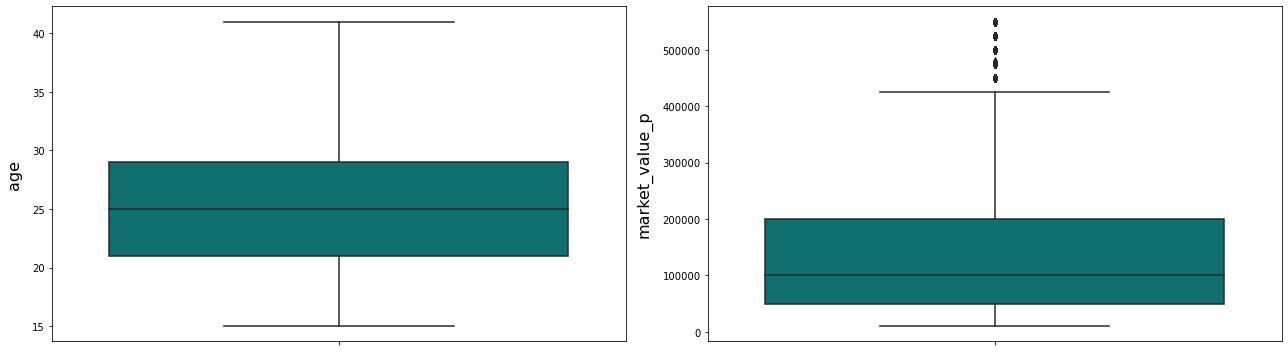

In [845]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=dataset[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();


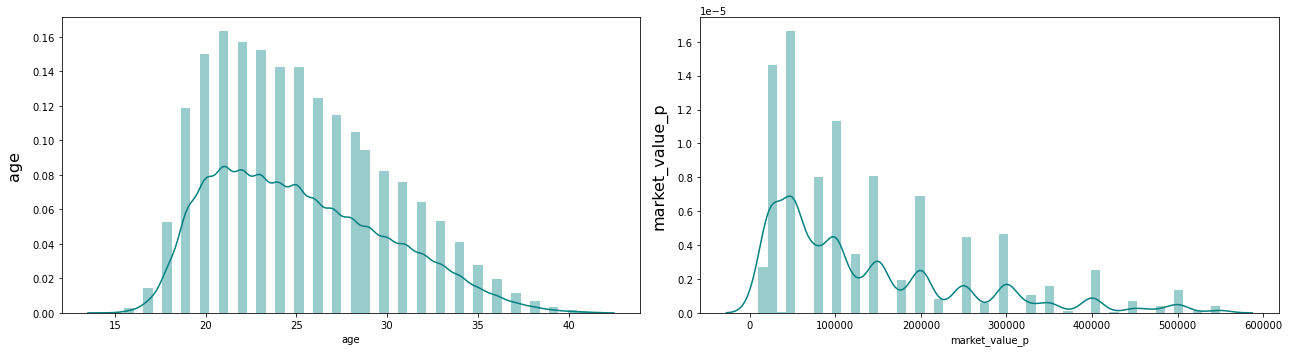

In [846]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(dataset[cols[index]], color='teal')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

#### Count Plot For Categorical Features

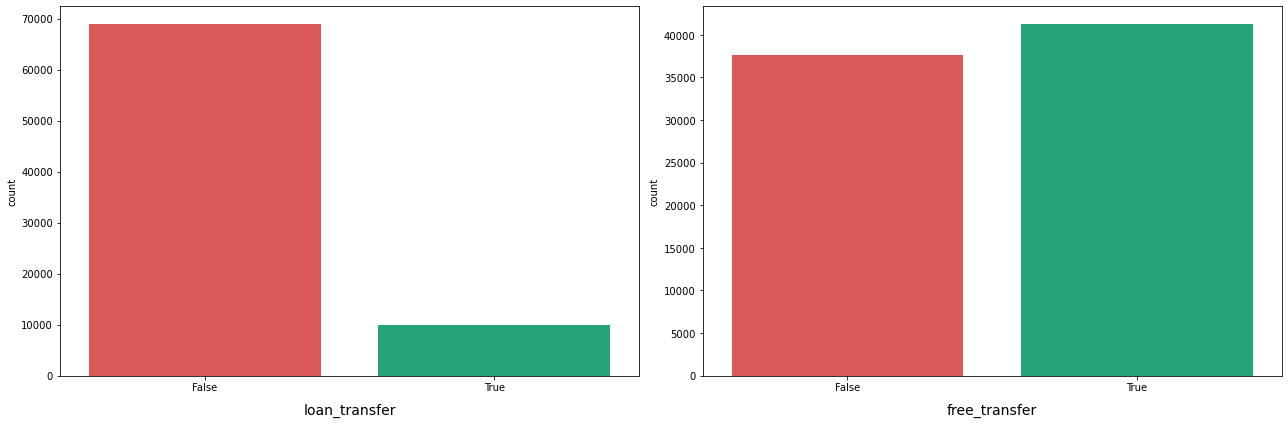

In [854]:
idf = dataset.select_dtypes(include='bool')
cols = idf.columns.tolist()

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, 2, index+1)
    sns.countplot(idf[cols[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(cols[index], fontsize='14', labelpad=10)

plt.show();

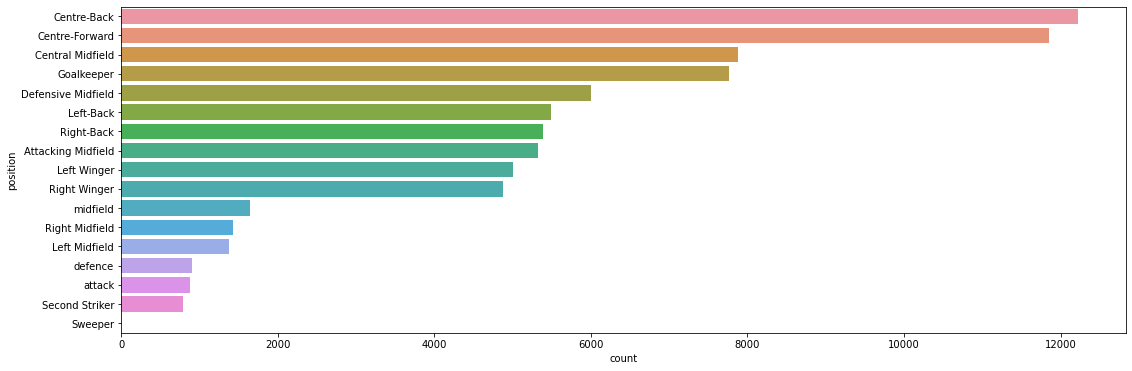

In [848]:
idf = dataset.groupby(['position'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='position', x='count', data=idf)
plt.show();

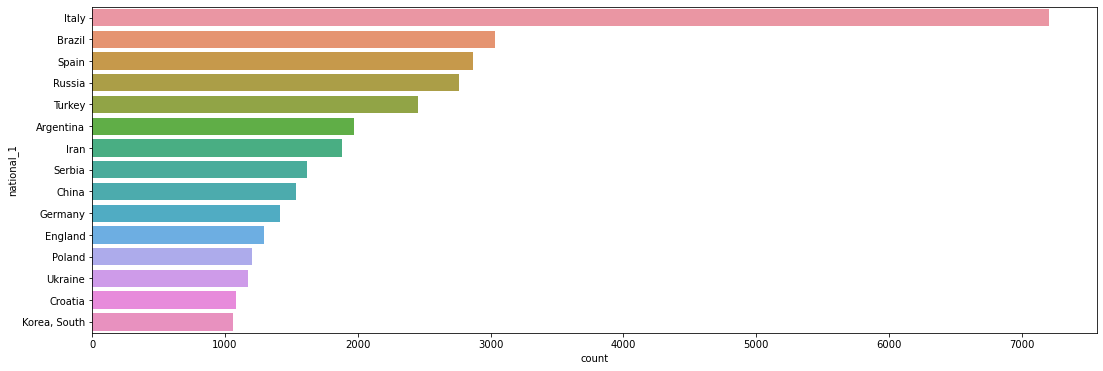

In [849]:
idf = dataset.groupby(['national_1'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='national_1', x='count', data=idf[:15])
plt.show();

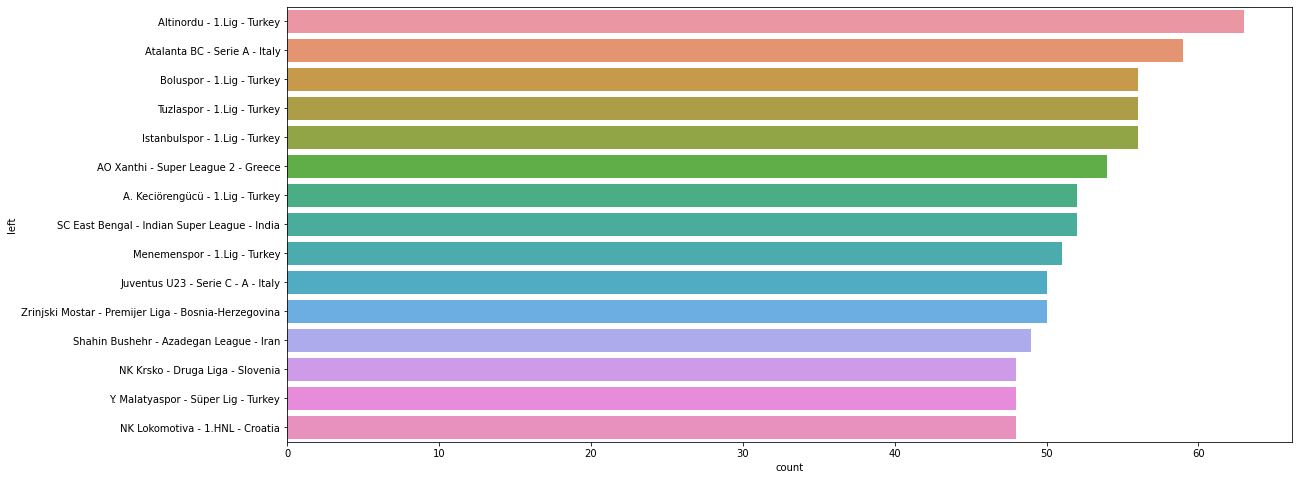

In [850]:
idf = dataset.groupby(['left'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,8))
sns.barplot(y='left', x='count', data=idf[:15])
plt.show();

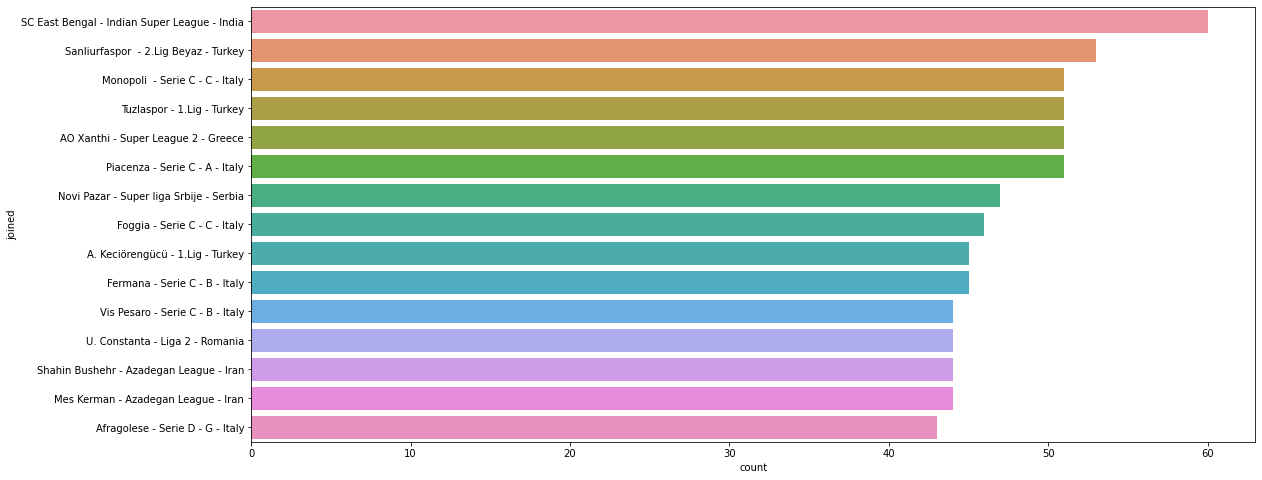

In [851]:
idf = dataset.groupby(['joined'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,8))
sns.barplot(y='joined', x='count', data=idf[:15])
plt.show();

### Multivariate Analysis

#### Correlation Heatmap

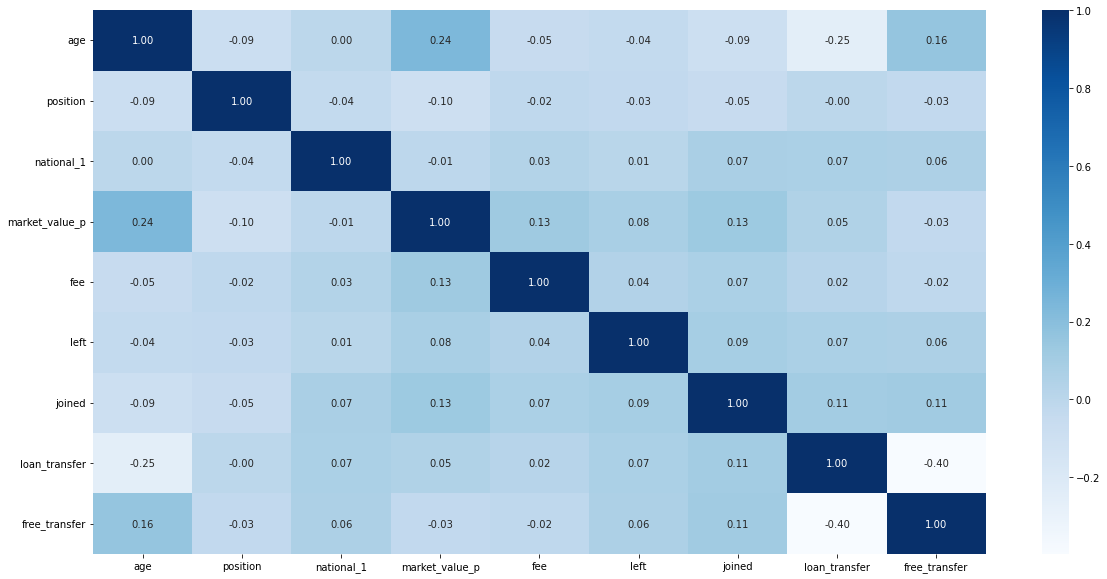

In [852]:
# label encoding for heatmap
idf = dataset.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

#### Pairplot

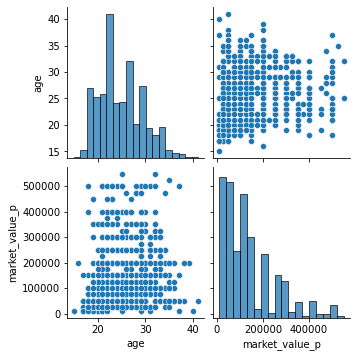

In [857]:
idf = dataset.select_dtypes(include='number')

sns.pairplot(data=idf.sample(1000, random_state=1), palette='teal')
plt.show();